# Code to create figures 3.a-f, 4.a-f, B.1.1, B.1.2, B.2.1, B.2.2, B.3.1, B.3.2, B.4.1, B.4.2, B.5.1, B.5.2,
### Moisture Sources Map and Barcharts
Can create moisture sources climatology and 2023 for all 5 sink regions.

Used in the manuscript,  
Evaporative Moisture Sources of Colorado’s Front Range: A Case Study of the Exceptionally Wet May-July Season of 2023

In [1]:
#Import Statements and Functions
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter
from matplotlib.transforms import ScaledTranslation
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings("ignore")

def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""
    
def flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i

Period           May            June          July              MJJ
FTR     53930904.375  41987241.40625  46201650.625  142119796.40625 climatology
Period            May           June          July             MJJ
FTR     88256583.3125  119438383.375  61931878.125  269626844.8125 2023
nfr done


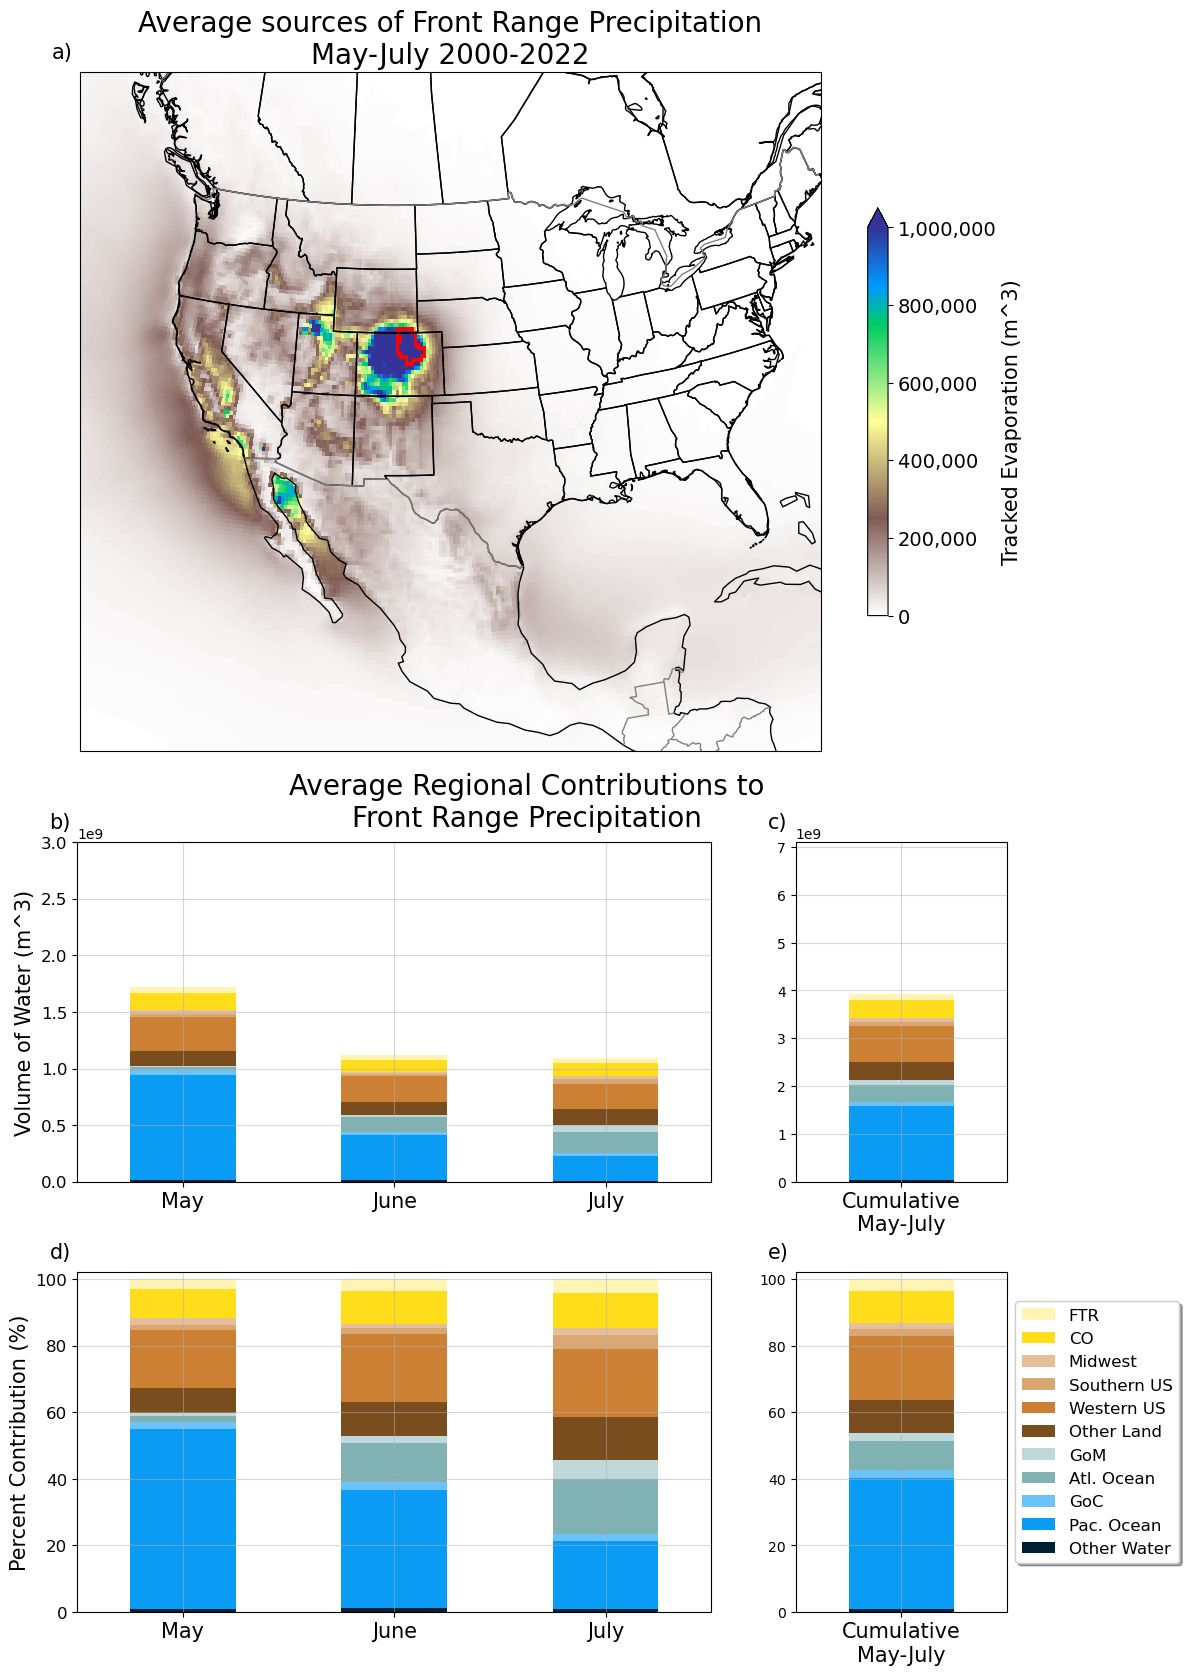

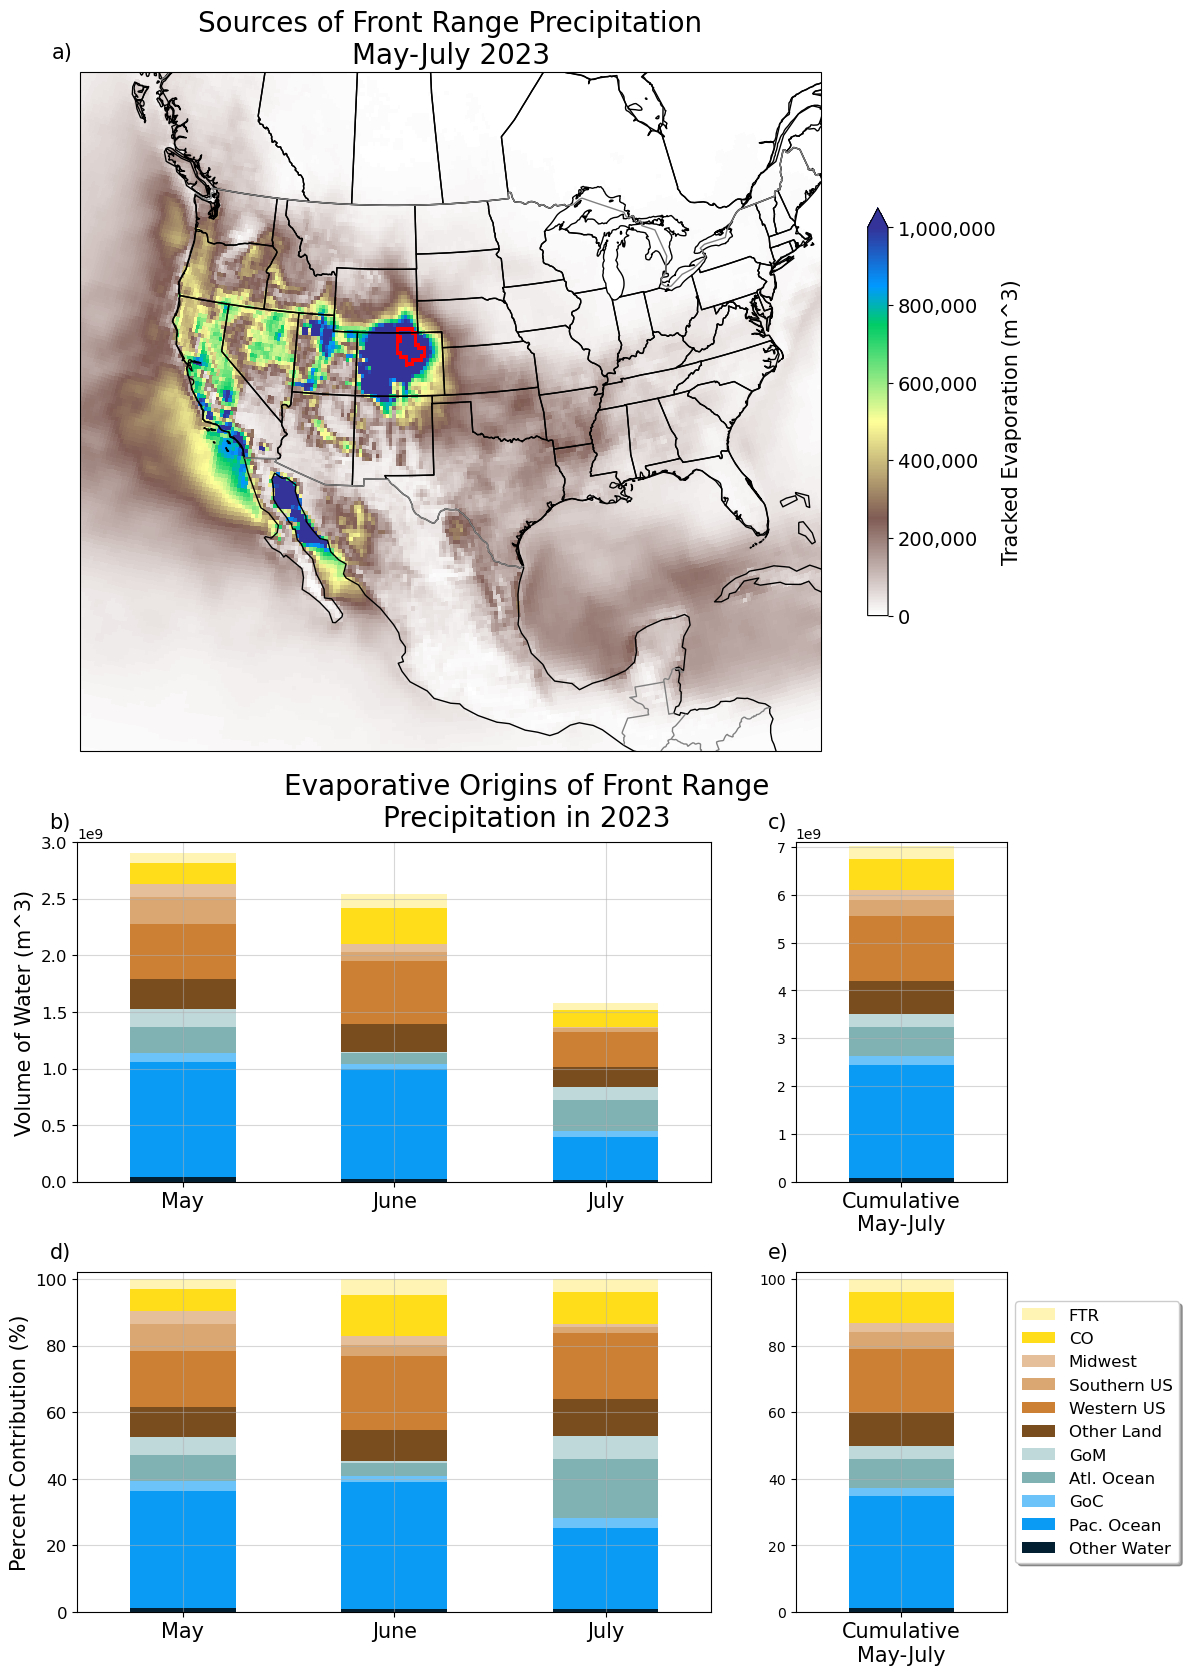

In [2]:
#MODIFY---------
save_plots = True
plot_sink_regions= ['nfr'] #['se', 'ne','nfr','pp','sp'] # abreviation as saved in file structure
ylim = 3*10**9 #max value on subplot b (monthly total e-track) 
                #nfr, pp, and sp use->3*10**9 #se and ne use -> 5*10**9 
total_lim = 7.1*10**9 #max value on subplot c (3 month total e-track) 
                #nfr, pp, and sp use->7.1*10**9 #se and ne use -> 12*10**9
map_limit = (1*10**6) #m^3 #max value on map color bar.
type_list = ['climatology', '2023'] #options: ['climatology', '2023']
view = 'n_america' #options to change map extent colorado, n_america, global
log_cbar = False #change colorbar from standard to log

wam_data_folder = '/Users/kathum/Research/COPEX/aggregated_files/wam_output/' #filepath to where aggregated wam_output is saved
save_figure_folder = '/Users/kathum/Research/COPEX/figures/' #where to save figures
sink_region_masks_folder = '/Users/kathum/Research/COPEX/sink_region_files/masks/eastern_co/' #Where the sink region netCDFs are located

#---------------

#conventions
region_info = pd.read_csv("/Users/kathum/Research/COPEX/sink_region_files/source_region_information.csv")
month_names = ['Jan', 'Feb', 'Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']
select_months = ['May', 'June', 'July'] #Months to plot
months = [5,6,7] #months to plot

#create dataframe to hold the percent increse information
perc_increase = pd.DataFrame(month_names, columns=['Period'])

#Loop to create a plot for each sink region in sink_region_names_list-------------------------------
for sink_region_name in plot_sink_regions: 
    region_alt_acronym = region_info.loc[region_info['other_acronym']== sink_region_name, 'short_name'].item()
    
    #Set correct directories for the sink regions
    DATA_DIRECTORY = f'{wam_data_folder}aggregated_co_altclimate_'+sink_region_name+'_2000_2023/'
    SAVE_DIRECTORY = f'{save_figure_folder}2000-2023_'+sink_region_name+'/'+ datetime.today().strftime('%m_%d_%Y') +'/' #creates a new folder for each day script is run, keep track of figure versions
    SINK_R_DIRECTORY = f'{sink_region_masks_folder}' #Where the sink region netCDFs are located
    #create a new directory if needed
    if save_plots == True:
        if not os.path.exists(SAVE_DIRECTORY):
            os.makedirs(SAVE_DIRECTORY)
            print('created new directory at: ', SAVE_DIRECTORY)
            
    #loop to go through creating figures for both climatology and 2023-----------------------------
    for type in type_list:
        #Calculate the total and relative contributions for each month
        monthly_data = pd.DataFrame(month_names, columns=['Period']) #create data frame to hold values
        monthly_data['avg_total_e (m^3)'] = pd.Series()
        
        #create a flat list of the selected month files 
        files = []
        for month_num in months:
            files.append(glob.glob(DATA_DIRECTORY+"*"+f'-{month_num:>02}.nc'))
        files = sorted(flatten(files))
        
        #based on climatology or 2023, select specified files    
        if type == 'climatology':
            all_mnths_ds = xr.open_mfdataset(files).sel(time = slice('2000-01-01','2022-12-31'))['e_track'] #grab the e-track data from all januaries or sept etc.
        elif type == '2023':
            all_mnths_ds = xr.open_mfdataset(files).sel(time = slice('2023-01-01','2023-09-30'))['e_track']#grab 2023 data only (leaving out data after september)

        #Create data for map of MJJ E-track-----
        yr_data = all_mnths_ds.resample(time = '1Y').sum() #group by year and sum all months in that year to get yearly MJJ E-track
        yr_data = yr_data.mean(dim='time') #average over years to get avg MJJ E-track 
        
        for month_num in range(5,7+1): #loop through all selected months to create bar charts-----------------------------------
            #filter to specified month
            sel_month_ds = all_mnths_ds.sel(time=all_mnths_ds.time.dt.month == month_num).mean(dim='time')
            
            #save list of all masks
            all_masks = []
            
            #calculate MONTHLY AVERAGE of TOTAL/ABSOLUTE E-TRACK
            avg_total_e = float(sel_month_ds.sum(['latitude', 'longitude']).values) #total e-track across space and then take the monthly average through time
            monthly_data.loc[monthly_data['Period']== month_names[month_num-1], 'avg_total_e (m^3)'] = avg_total_e #fill in value in pandas table

            #calculate MONTHLY AVERAGE of ABSOLUTE REGION SPECIFIC E-TRACK
            columns_2_plot = ['Period']
            sel_region_info = region_info[(~region_info['clim_division'])|(region_info['other_acronym']== sink_region_name)] #select the source regions excluding the other climate divisions
            
            #iterate through each source region to calc regional contributions-------------------------------------
            for i, region in sel_region_info.iterrows():
                if month_num == 1: #create a new column only if it hasnt been created before
                    monthly_data['avg_'+region['short_name']+'_e (m^3)'] = pd.Series()
                    
                #read in the mask associated with this region
                if region['region_name'].capitalize() == 'Colorado':
                    mask = xr.open_dataarray(region['mask_filepath'])
                    #remove the sink region from this mask
                    remove_mask = xr.open_dataarray(region_info.loc[region_info['other_acronym']== sink_region_name, 'mask_filepath'].item())
                    mask = mask - remove_mask
                    mask = mask.where(mask>0, other = 0)
                    remove_mask.close()
                elif region['region_name'].lower() == 'western us':
                    #remove colorado and the sink region from this mask
                    mask = xr.open_dataarray(region['mask_filepath'])
                    for remove_region in [region_info.loc[region_info['other_acronym']== sink_region_name, 'region_name'].item(), 'Colorado']:
                        remove_mask = xr.open_dataarray(region_info.loc[region_info['region_name']== remove_region, 'mask_filepath'].item())
                        mask = mask - remove_mask
                    mask = mask.where(mask == 1, other = 0)
                    remove_mask.close()
                elif region['region_name'] == 'Other Water':
                    mask = 1 - xr.open_dataarray('/Users/kathum/Research/COPEX/sink_region_files/masks/land_source_region.nc') 
                    mask = mask.squeeze()
                    water_mask_paths = sel_region_info.loc[(sel_region_info['surface_type'].notnull()), ['mask_filepath']].values.squeeze()
                    for path in water_mask_paths:
                        remove_mask =  xr.open_dataarray(path)
                        mask = mask - remove_mask
                    remove_mask.close()
                    mask = mask.where(mask>0, other = 0)
                elif region['region_name'] == 'Other Land':
                    mask = xr.open_dataarray('/Users/kathum/Research/COPEX/sink_region_files/masks/land_source_region.nc')
                    mask = mask.squeeze()
                    land_mask_paths = sel_region_info.loc[(sel_region_info['surface_type'].notnull()), ['mask_filepath']].values.squeeze()
                    for path in land_mask_paths:
                        remove_mask =  xr.open_dataarray(path)
                        mask = mask - remove_mask
                    remove_mask.close()
                    mask = mask.where(mask>0, other = 0)    
                else:
                    mask = xr.open_dataarray(region['mask_filepath'])
                    
                #Calculate regional contribution
                region_e = (sel_month_ds * mask).sum(['latitude', 'longitude']).values #calculate region contribution
                monthly_data.loc[monthly_data['Period']== month_names[month_num-1], 'avg_'+region['short_name']+'_e (m^3)'] = region_e #add it to dataframe
                columns_2_plot.append('avg_'+region['short_name']+'_e (m^3)') #keeps track of which columns to plot
                all_masks.append({'name':region['region_name'],'b_mask':mask}) #stores the mask in all_masks varable for refference
                
                #close unneeded xarray variables
                mask.close() 
                sel_month_ds.close()

        #clean up dataframe before plotting
        data_plot = monthly_data[columns_2_plot] #removes unessesary columns
        data_plot.columns = ['Period'] + [find_between(col_name, '_','_') for col_name in data_plot.columns[1:]] #cleans up column names 
        data_plot = data_plot.loc[data_plot.Period.isin(select_months)].reset_index(drop=True)
        
        #calculate percent contribution
        pc_df = pd.DataFrame(data_plot['Period'], columns=['Period'])
        monthly_data.replace(0,np.nan,inplace=True) #ensure any e-track of exactly zero is nan
        pc_df = pd.DataFrame(monthly_data['Period'], columns=['Period'])
        for column in columns_2_plot[1:]:
            new_col = find_between(column, '_','_e')
            pc_df[new_col] = (monthly_data[column] / monthly_data['avg_total_e (m^3)']) * 100
        pc_df = pc_df.loc[pc_df['Period'].isin(select_months)].reset_index(drop=True) #filter pc_df to select months


        #Calculate MJJ cummulative
        mjj = data_plot.sum(axis=0).iloc[1:]
        mjj_df = pd.DataFrame(mjj).transpose().rename( index={0: 'Cumulative\nMay-July'})
        #Calc MJJ percent contirbution
        mjj_pc_df = (mjj_df/mjj_df.sum(axis=1).values[0])*100
        
        #All Plotting-----------------------
        # Define figure with two sections (map on top, bar charts on bottom)
        fig = plt.figure(figsize=(12, 20))
        gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1])
        fig_labels = ['a)', 'b)', 'c)', 'd)', 'e)']
        
        #Map plotting
        ax_map = fig.add_subplot(gs[0], projection=ccrs.LambertConformal(central_longitude=-106))

        # Define view box
        if view == 'n_america':
            view_box = [-125, -80, 15, 55]
        elif view in ['colorado', 'co']:
            view_box = [-111, -100, 36, 42]
        elif view in ['global', 'world']:
            view_box = [0, 360, 10, 75]
        else:
            raise ValueError('Invalid view input')

        # Plot moisture source data
        plot1 = yr_data.plot(
            x='longitude',
            y='latitude',
            vmin=0,
            vmax=map_limit,
            transform=ccrs.PlateCarree(central_longitude=0),
            cmap='terrain_r',
            ax=ax_map, add_colorbar=False
        )
        #lognormal plot
        if log_cbar:
            plot1 = yr_data.plot(
                norm=LogNorm(vmin=1, vmax=map_limit),  # adjust vmin if needed based on data
                transform=ccrs.PlateCarree(central_longitude=0),
                cmap='terrain_r',
                ax=ax_map, add_colorbar=False)
        cb = plt.colorbar(plot1, ax=ax_map, shrink=0.6, format=FuncFormatter(lambda x, p: format(int(x), ',')), extend='max')
        cb.set_label(label='Tracked Evaporation (m^3)', size=15)
        cb.ax.tick_params(labelsize=14)

        # Add region overlay to plot1
        region_file_name = {'ne': 'Northeast', 'nfr':'Northern_Front_Range', 'pp':'Pikes_Peak', 'sp':'South_Park', 'se':'Southeast'}
        region = xr.open_dataarray(SINK_R_DIRECTORY + 'co_AltClimate_' + region_file_name[sink_region_name] + '_source_region.nc')
        region_roll = region.rolling(latitude=3, longitude=3, center=True).sum()
        region.where((region_roll < 9.0) & (region_roll >= 1) & (region == 0)).plot(cmap='brg', add_colorbar=False, ax=ax_map, transform=ccrs.PlateCarree(central_longitude=0))
        region.close()

        # Map features
        region_title_name = {'ne': 'Eastern Plains', 'nfr':'Front Range', 'pp':'Pikes Peak', 'sp':'High Mountain Valley', 'se':'Arkansas Basin'}
        if type == '2023':
            title_text = f'Sources of {region_title_name[sink_region_name]} Precipitation\nMay-July 2023'
        elif type == 'climatology':
            title_text = f'Average sources of {region_title_name[sink_region_name]} Precipitation\nMay-July 2000-2022' 
        ax_map.set_title(title_text, size=20)
        ax_map.add_feature(cfeature.STATES)
        ax_map.coastlines(resolution='110m')
        ax_map.set_extent(view_box, crs=ccrs.PlateCarree())
        ax_map.add_feature(cfeature.BORDERS, color='grey')
        ax_map.text(0.0, 1.0, fig_labels[0], 
                         transform=(ax_map.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),fontsize=15, va='bottom')#, fontfamily='serif')
 
        # ----- Bar Chart Plotting: Absolute qualities ----- 
        gs_bottom = gs[1].subgridspec(1, 2, width_ratios=[3, 1])
        axs = [fig.add_subplot(gs_bottom[0]), fig.add_subplot(gs_bottom[1])]

        # Custom colormap
        my_cmap = ListedColormap(["#021f31", "#0a9bf5", '#6cc3f9', '#80b1b3', '#bfd8d9', '#7a4d1f', '#cb8034', '#daa671', '#e5bf9a', "#ffdd1a", "#fff4b3"])

        #plot the monthly bar charts
        data_plot.plot(x='Period', kind='bar', stacked=True, colormap=my_cmap, ax=axs[0], rot=0, legend=False)
        
        #Set figure parameters
        title_lab = {
            'climatology': [f'Average Regional Contributions to\n{region_title_name[sink_region_name]} Precipitation', f'Average Regional Percent Contributions to {region_title_name[sink_region_name]} Precipitation'],
            '2023': [f'Evaporative Origins of {region_title_name[sink_region_name]}\nPrecipitation in 2023', 'Percentage of Precipitation Origin']
        }
        axs[0].set_ylabel('Volume of Water (m^3)', fontsize=15)
        axs[0].set_xlabel(' ')
        axs[0].grid(alpha=0.5)
        axs[0].set_ylim([0, ylim])
        axs[0].tick_params(axis='x', labelsize=15)
        axs[0].tick_params(axis='y', labelsize=12)

        #plot MJJ bars
        mjj_df.plot(kind='bar', stacked=True, colormap=my_cmap, ax=axs[1], legend=False, rot=0)
        
        #figure parameters
        axs[1].grid(alpha=0.5)
        axs[1].tick_params(axis='x', labelsize=15)
        axs[1].set_ylim([0, total_lim])
        plt.suptitle(title_lab[type][0], fontsize=20, y = 0.53)

        # Legend
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(0.9, 0.2),fancybox=True, shadow=True, fontsize=12)
        for i in range(2):
            # Put the label at the top left corner (axes fraction (0, 1)), - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),i.e. just outside the axes.
            axs[i].text(0.0, 1.0, fig_labels[i+1], 
                         transform=(axs[i].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),fontsize=15, va='bottom')#, fontfamily='serif')
         
        # ----- Bar Chart Plotting: Relative quantities ----- 
        gs_bottom2 = gs[2].subgridspec(1, 2, width_ratios=[3, 1])
        axs2 = [fig.add_subplot(gs_bottom2[0]), fig.add_subplot(gs_bottom2[1])]
        
        #plot monthly
        pc_df.plot(x='Period', kind='bar', stacked=True, colormap=my_cmap, ax=axs2[0], rot=0, legend=False)
        axs2[0].set_ylabel('Percent Contribution (%)', fontsize=15)
        axs2[0].set_xlabel(' ')
        axs2[0].grid(alpha=0.5)
        axs2[0].set_ylim([0, 102])
        axs2[0].tick_params(axis='x', labelsize=15)
        axs2[0].tick_params(axis='y', labelsize=12)

        #plot MJJ cumulative
        mjj_pc_df.plot(kind='bar', stacked=True, colormap=my_cmap, ax=axs2[1], legend=False, rot=0)
        axs2[1].grid(alpha=0.5)
        axs2[1].tick_params(axis='x', labelsize=15)
        axs2[1].set_ylim([0, 102])
        plt.suptitle(title_lab[type][0], fontsize=20, y = 0.53)        
        
        for i in range(2):
            # Use ScaledTranslation to put the label - at the top left corner (axes fraction (0, 1)), - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),i.e. just outside the axes.
            axs2[i].text(0.0, 1.0, fig_labels[i+3], 
                         transform=(axs2[i].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),fontsize=15, va='bottom')#, fontfamily='serif')
        
        if save_plots == True: #save figure
            if log_cbar:
                plot_name = f'{type}_{sink_region_name}_MJJ_stacked_bar_monthly_e_track_logscale.png'
            else:
                plot_name = f'{type}_{sink_region_name}_MJJ_stacked_bar_monthly_e_track.png'
            plt.savefig(SAVE_DIRECTORY+plot_name, bbox_inches='tight',dpi=400)
        #----- save information for tables in manuscript -------
        #add "Period" columns for mjj_df and mjj_pc_df
        mjj_df["Period"] = "MJJ" 
        mjj_pc_df["Period"] = "MJJ"

        #reorder columns sine the new column is moved to the back
        mjj_df = mjj_df[["Period"] + [col for col in mjj_df.columns if col != "Period"]]
        mjj_pc_df = mjj_pc_df[["Period"] + [col for col in mjj_pc_df.columns if col != "Period"]]

        #combine monthly and MJJ dfs
        absolute_combined = pd.concat([data_plot,mjj_df], ignore_index=True).set_index("Period")
        relative_combined = pd.concat([pc_df,mjj_pc_df], ignore_index=True).set_index("Period")

        #transpose for easy viewing later
        absolute_combined = absolute_combined.iloc[::, ::-1].transpose()
        relative_combined = relative_combined.iloc[::, ::-1].transpose()
        
        #combine CO and FTR since the regions are so small
        absolute_combined.loc["CO+FTR"] = absolute_combined.loc[["CO","FTR"]].sum()
        relative_combined.loc["CO+FTR"] = relative_combined.loc[["CO","FTR"]].sum()
        
        #reorder columns and remove co and FTR
        print(absolute_combined.loc[['FTR']], type)
        absolute_combined = absolute_combined.loc[["CO+FTR"] + absolute_combined.index[2:-1].tolist()]
        relative_combined = relative_combined.loc[["CO+FTR"] + relative_combined.index[2:-1].tolist()]
        
        #save combined dfs to computer
        absolute_combined.to_csv(f"{SAVE_DIRECTORY}{type}_absolute_combined.csv")
        relative_combined.to_csv(f"{SAVE_DIRECTORY}{type}_relative_combined.csv")   
    
    print(sink_region_name + ' done')